# 交通事故資料分析與預處理流程說明

---

## 1. 資料載入與初步探索（Data Loading & Basic Inspection）

### 功能
- 載入 CSV 檔案
- 顯示資料集基本資訊（資料量、欄位名稱）
- 檢查每欄資料型別
- 分析缺失值狀況

### 原理
- 使用 `pandas.read_csv()` 讀取資料
- 使用 `df.info()` 和 `df.describe()` 檢視統計摘要
- 使用 `df.isnull().sum()` 檢查缺失值分布

---

## 2. 資料清理與標準化（Data Cleaning & Normalization）

### 功能
- 時間欄位轉為 `datetime` 格式
- 擷取時間特徵（小時、週幾、月份等）
- 天氣條件欄位標準化
- 移除或修正數值型異常值

### 原理
- 使用 `pd.to_datetime()` 處理時間格式
- 使用 `.dt` 屬性擷取時間欄位細節
- 建立天氣條件轉換字典進行對應修正
- 使用 IQR 方法識別並修正異常值

---

## 3. 探索性資料分析（EDA: Exploratory Data Analysis）

### 功能
- 分析事故嚴重度 (`Severity`) 分布
- 時間模式探索（每日／每週趨勢）
- 天氣對事故的影響
- 數值特徵分布（如能見度、風速）
- 地理熱點與州別分布
- 道路類型與事故關聯分析

### 原理
- 使用 `value_counts()` 分析類別分布
- 使用 `groupby()` 進行統計聚合
- 使用 `pd.crosstab()` 交叉分析變數
- 使用箱型圖（boxplot）觀察極端值
- 使用熱力圖觀察特徵間的相關性

---

## 4. 特徵工程與選擇（Feature Engineering）

### 功能
- 類別特徵編碼（如 One-Hot 編碼）
- 建立交互特徵（例如：天氣 × 時段）
- 時間特徵轉換（如是否尖峰、週末等）
- 使用隨機森林進行特徵重要性分析
- 計算特徵間的相關係數矩陣
- 分析時間與天氣的組合關係
- 分析地點與天氣的組合關係
- 使用 SelectKBest 進行特徵選擇
- 建立新的時間特徵（尖峰時段、夜間、週末）
- 建立新的天氣特徵（惡劣天氣、良好能見度）
- 建立新的地點特徵（都市區域）

### 原理
- 使用 RandomForestClassifier 計算特徵重要性分數
- 使用 corr() 計算特徵相關係數
- 使用 crosstab() 分析特徵組合關係
- 使用 SelectKBest 和 f_classif 進行統計檢定
- 使用布林運算建立時間相關特徵
- 使用條件判斷建立天氣相關特徵
- 使用邏輯運算建立地點相關特徵



In [22]:
# %% [markdown]
# # 車禍資料分析與特徵工程

# %%
# 導入必要的套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import gc
from IPython.display import display, HTML

# 設定顯示選項
warnings.filterwarnings('ignore')
plt.ioff()  # 關閉互動模式
plt.style.use('default')  # 使用更簡單的樣式
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 設定圖表大小
plt.rcParams['figure.figsize'] = [6, 4]  # 減小默認圖表大小
plt.rcParams['figure.dpi'] = 100  # 降低圖表解析度

# %%
# 載入資料
print("正在載入資料...")
df = pd.read_csv("undersampled_2022.csv")

# %%
# 顯示基本資料資訊
print("\n=== 基本資料資訊 ===")
print(f"資料集大小: {df.shape}")



# %%
# 顯示數值型變量統計
print("\n=== 數值型變量統計 ===")
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for i in range(0, len(numeric_cols), 5):
    chunk_cols = numeric_cols[i:i+5]
    display(df[chunk_cols].describe().style.background_gradient(cmap='YlOrRd'))
    gc.collect()

# %%
# 顯示缺失值統計
print("\n=== 缺失值統計 ===")
missing_stats = df.isnull().sum()
missing_df = pd.DataFrame({
    '缺失值數量': missing_stats,
    '缺失比例': (missing_stats / len(df) * 100).round(2)
})
display(missing_df[missing_df['缺失值數量'] > 0].style.background_gradient(cmap='YlOrRd'))






正在載入資料...

=== 基本資料資訊 ===
資料集大小: (143520, 44)

=== 數值型變量統計 ===


,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F)
count,143520.000000,143520.000000,143520.000000,143520.000000,143520.000000
mean,2.500000,36.484823,-90.600340,0.590699,64.742712
std,1.118038,4.731206,15.572583,2.203922,19.233934
min,1.000000,24.589540,-124.466551,0.000000,-35.000000
25%,1.750000,33.692510,-97.175520,0.000000,54.000000
50%,2.500000,36.329437,-84.203328,0.019000,69.000000
75%,3.250000,40.120708,-79.553808,0.389000,79.000000
max,4.000000,48.974396,-68.283783,336.570007,162.000000


,Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph)
count,143520.000000,143520.000000,143520.000000,143520.000000,143520.000000
mean,63.622924,65.081557,29.263784,9.222322,7.207797
std,21.438462,22.759535,1.209655,2.236583,5.377700
min,-63.000000,2.000000,19.640000,0.000000,0.000000
25%,54.000000,48.000000,29.120000,10.000000,3.000000
50%,69.000000,67.000000,29.560000,10.000000,7.000000
75%,79.000000,84.000000,29.910000,10.000000,10.000000
max,162.000000,100.000000,58.390000,60.000000,132.000000


,Precipitation(in)
count,143520.000000
mean,0.005690
std,0.049147
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,3.190000



=== 缺失值統計 ===


,缺失值數量,缺失比例


## 2. 資料清理與標準化

In [19]:
# %% [markdown]
# ## 2. 資料清理與標準化

# %%
# 時間處理
print("開始時間處理...")
df_clean = df.copy()
df_clean['Start_Time'] = pd.to_datetime(df_clean['Start_Time'], format='mixed')
df_clean['End_Time'] = pd.to_datetime(df_clean['End_Time'], format='mixed')

# 提取時間特徵
df_clean['Hour'] = df_clean['Start_Time'].dt.hour
df_clean['Day'] = df_clean['Start_Time'].dt.day
df_clean['Month'] = df_clean['Start_Time'].dt.month
df_clean['DayOfWeek'] = df_clean['Start_Time'].dt.dayofweek
df_clean['IsWeekend'] = df_clean['DayOfWeek'].isin([5, 6]).astype(int)
df_clean['IsRushHour'] = df_clean['Hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)

# %%
# 天氣條件標準化
print("開始天氣條件標準化...")
weather_conditions = {
    'Clear': ['Clear', 'Fair', 'Sunny'],
    'Cloudy': ['Cloudy', 'Overcast', 'Partly Cloudy', 'Mostly Cloudy'],
    'Rain': ['Rain', 'Light Rain', 'Heavy Rain', 'Drizzle', 'Showers'],
    'Snow': ['Snow', 'Light Snow', 'Heavy Snow', 'Sleet', 'Hail'],
    'Fog': ['Fog', 'Mist', 'Haze', 'Smoke', 'Dust'],
    'Windy': ['Windy', 'Breezy', 'Blustery'],
    'Other': ['Other', 'Unknown']
}

def standardize_weather(condition):
    if pd.isna(condition):
        return 'Other'
    for group, conditions in weather_conditions.items():
        if condition in conditions:
            return group
    return 'Other'

df_clean['Weather_Category'] = df_clean['Weather_Condition'].apply(standardize_weather)

# %%
# 數值特徵處理
print("開始數值特徵處理...")
numeric_features = ['Temperature(F)', 'Wind_Speed(mph)', 'Visibility(mi)', 'Distance(mi)']

# 處理異常值
outliers_summary = []
for feature in numeric_features:
    if feature in df_clean.columns:
        Q1 = df_clean[feature].quantile(0.25)
        Q3 = df_clean[feature].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df_clean[(df_clean[feature] < Q1 - 1.5*IQR) | 
                          (df_clean[feature] > Q3 + 1.5*IQR)][feature].count()
        outliers_summary.append({
            '特徵': feature,
            '異常值數量': outliers,
            '異常值比例': (outliers / len(df_clean) * 100).round(2)
        })
        df_clean[feature] = df_clean[feature].clip(lower=Q1 - 1.5*IQR, upper=Q3 + 1.5*IQR)

print("\n=== 異常值處理摘要 ===")
display(pd.DataFrame(outliers_summary).style.background_gradient(cmap='YlOrRd'))


開始時間處理...
開始天氣條件標準化...
開始數值特徵處理...

=== 異常值處理摘要 ===


,特徵,異常值數量,異常值比例
0,Temperature(F),2106,1.470000
1,Wind_Speed(mph),2821,1.970000
2,Visibility(mi),23175,16.150000
3,Distance(mi),20316,14.160000


## 3. 探索性資料分析 (EDA)


=== 1. 事故嚴重度分布 ===


,嚴重度,數量,比例
0,1,35880,25.000000
1,2,35880,25.000000
2,3,35880,25.000000
3,4,35880,25.000000


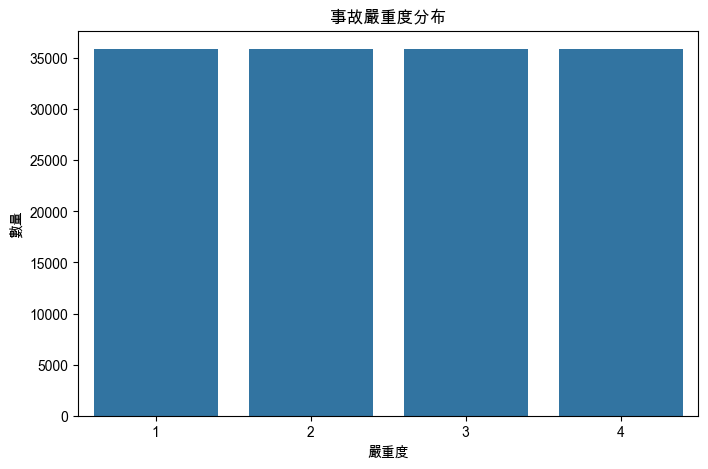


=== 2. 時間模式分析 ===

2.1 按小時分布


,事故數量,平均嚴重度
Hour,,
0,1872,3.260000
1,1469,3.200000
2,1691,2.990000
3,1598,2.960000
4,4472,2.090000
5,5310,2.200000
6,9113,2.070000
7,13873,1.950000
8,13719,1.930000


<Figure size 1000x500 with 0 Axes>

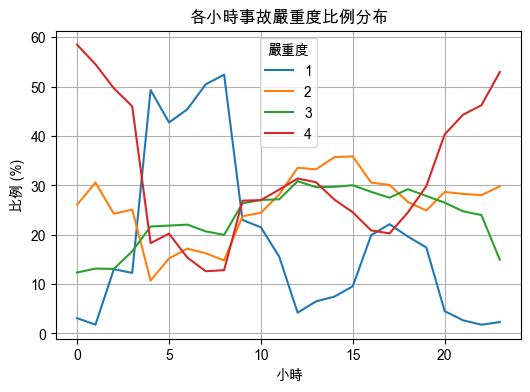


2.2 按星期分布


,事故數量,平均嚴重度
Weekday,,
週一,21995,2.410000
週三,25129,2.360000
週二,24248,2.370000
週五,24227,2.470000
週六,12263,3.040000
週四,25322,2.380000
週日,10336,3.070000


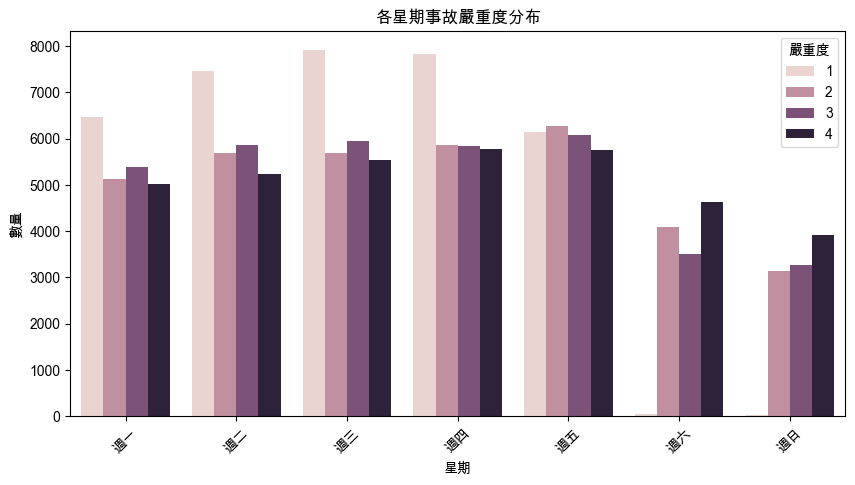


=== 3. 天氣影響分析 ===

3.1 天氣條件分布


,天氣條件,數量,比例
0,Clear,71908,50.100000
1,Cloudy,52739,36.750000
2,Rain,7305,5.090000
3,Other,6288,4.380000
4,Snow,2767,1.930000
5,Fog,2513,1.750000



3.2 天氣條件與事故嚴重度關係

各天氣條件下的事故數量：


Severity,1,2,3,4
Weather_Category,,,,
Clear,19316,17970,16322,18300
Cloudy,13835,12749,14004,12151
Fog,542,706,524,741
Other,1032,1706,1933,1617
Rain,1145,1866,2237,2057
Snow,10,883,860,1014



各天氣條件下的事故比例：


Severity,1,2,3,4
Weather_Category,,,,
Clear,26.862102,24.990265,22.698448,25.449185
Cloudy,26.232959,24.173761,26.553405,23.039876
Fog,21.567847,28.093912,20.851572,29.486669
Other,16.412214,27.131043,30.741094,25.715649
Rain,15.674196,25.544148,30.622861,28.158795
Snow,0.361402,31.911818,31.080593,36.646187


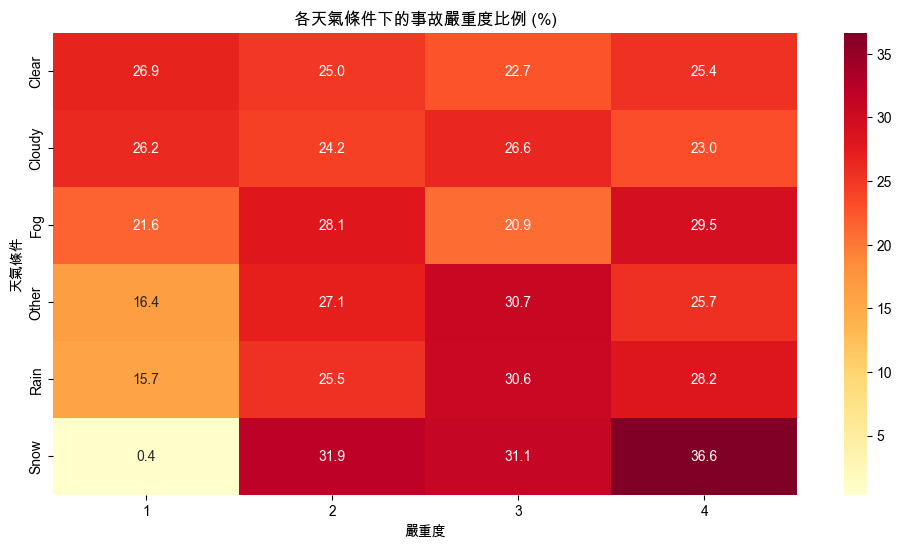


3.3 天氣條件與事故嚴重度的關係分析


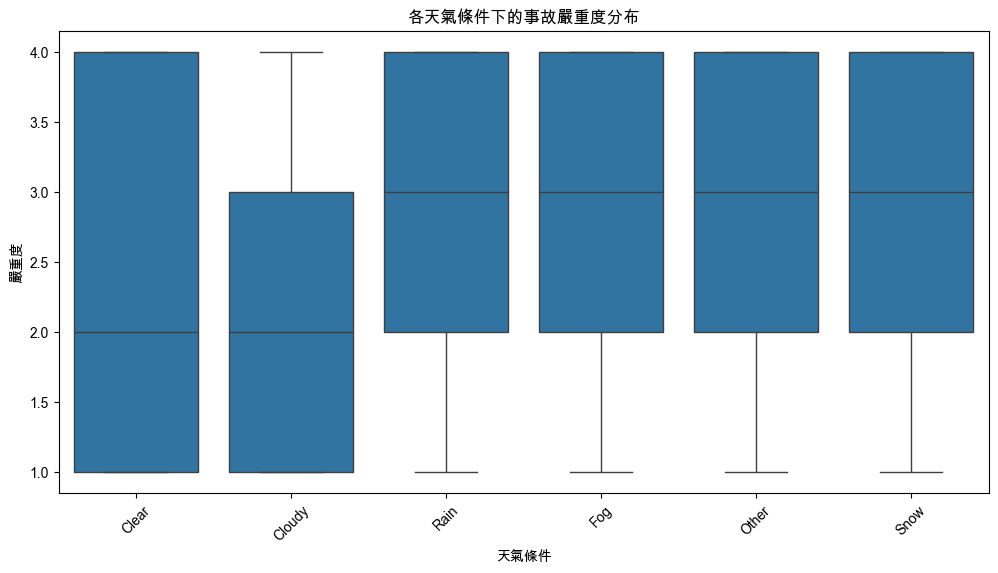


=== 4. 數值特徵分析 ===

4.1 數值特徵統計



4.2 數值特徵與嚴重度的關係


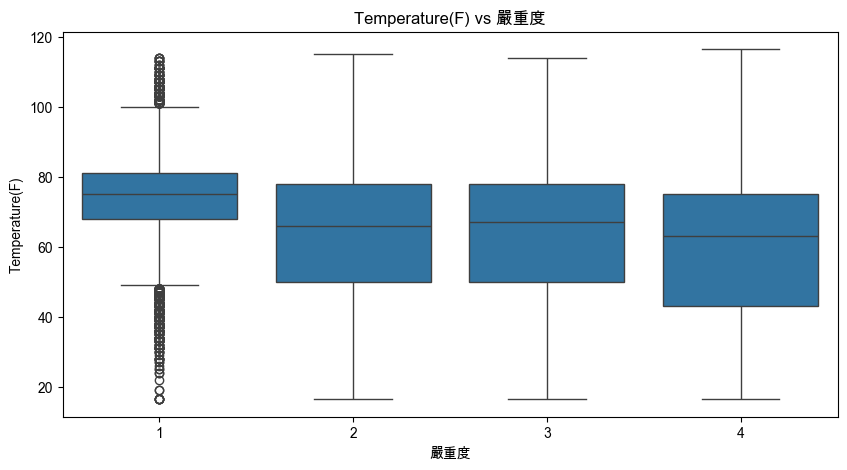

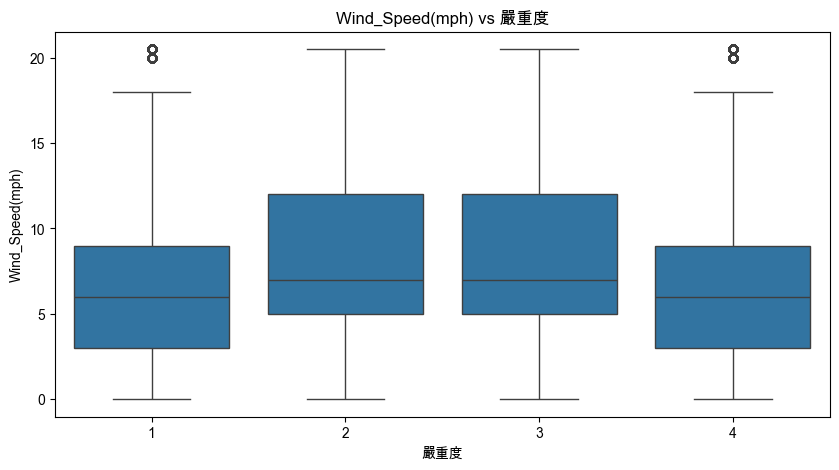

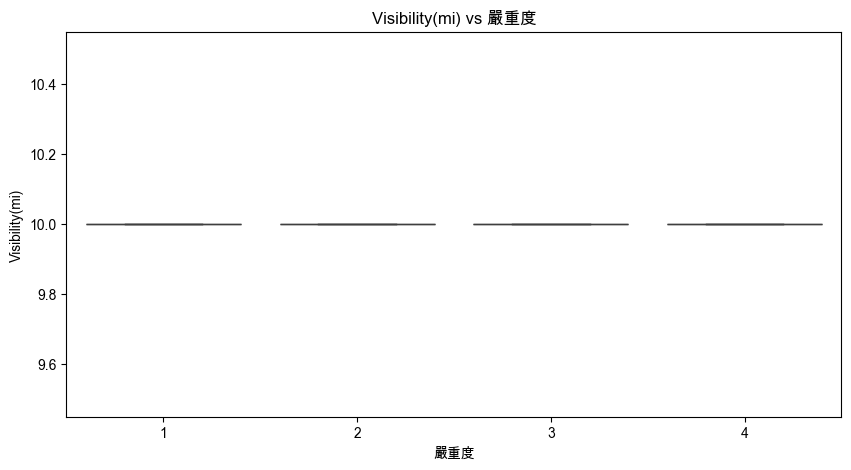

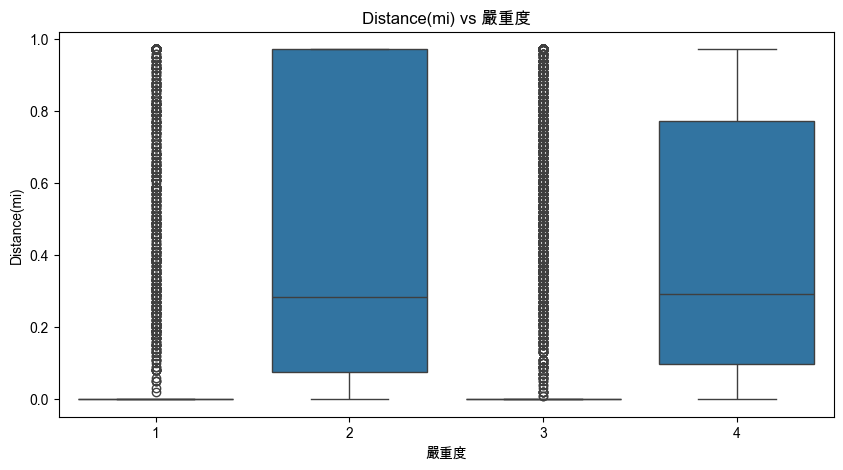


=== 5. 地理分布分析 ===


,州,事故數量,比例
0,CA,19624,13.670000
1,FL,13177,9.180000
2,TX,10257,7.150000
3,VA,10013,6.980000
4,SC,9245,6.440000
5,NC,8713,6.070000
6,PA,8139,5.670000
7,NY,5325,3.710000
8,GA,5108,3.560000
9,IL,4231,2.950000


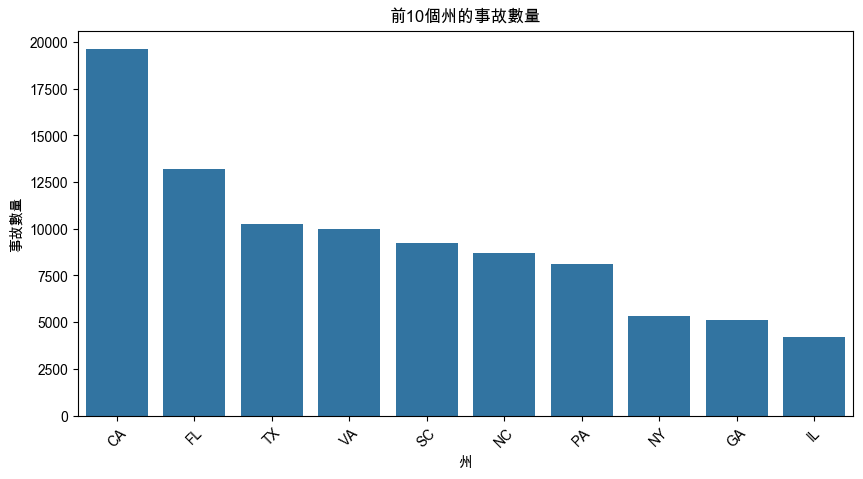


=== 6. 道路特徵分析 ===

6.1 道路特徵統計


,特徵,數量,比例
0,Traffic_Signal,20279,14.130000
1,Crossing,14393,10.030000
2,Junction,8358,5.820000
3,Stop,3992,2.780000
4,Station,3039,2.120000
5,Amenity,1565,1.090000
6,Railway,1197,0.830000
7,No_Exit,336,0.230000
8,Traffic_Calming,135,0.090000
9,Bump,51,0.040000



6.2 道路特徵與嚴重度的關係


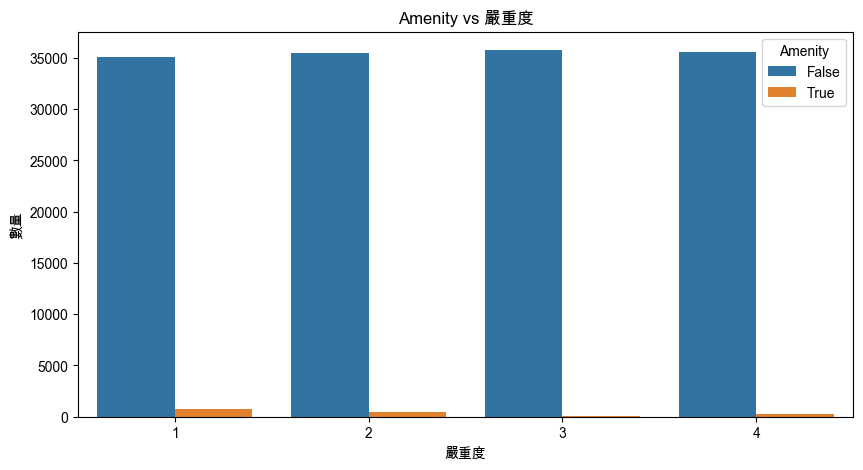

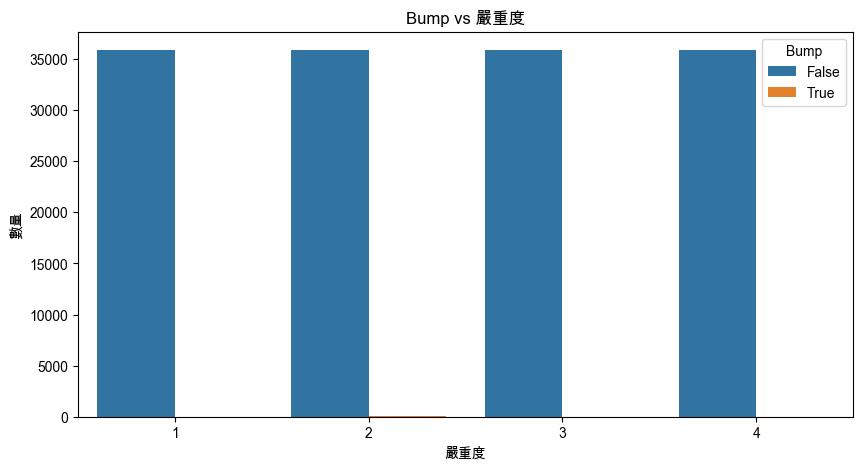

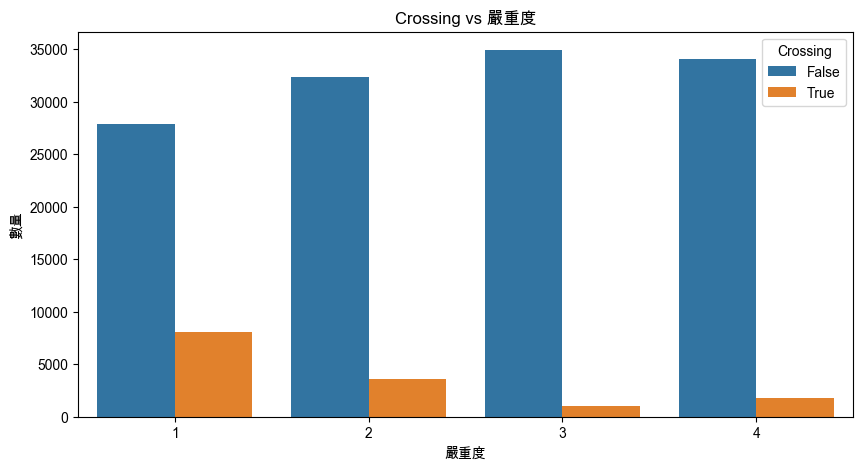

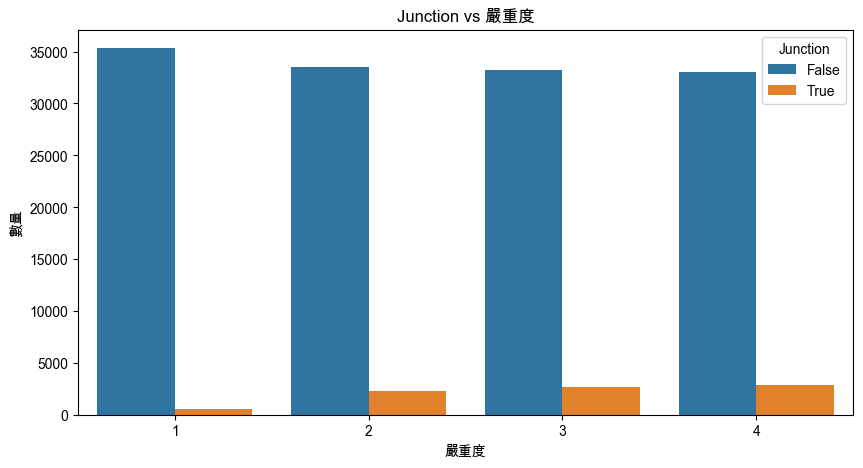

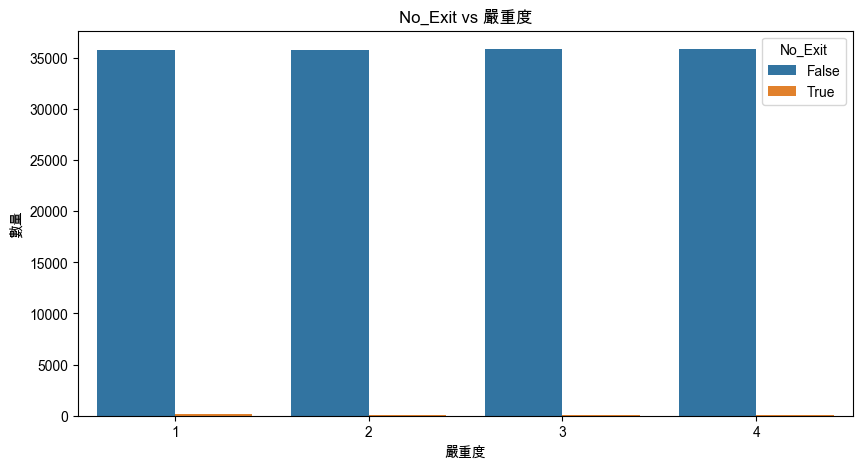

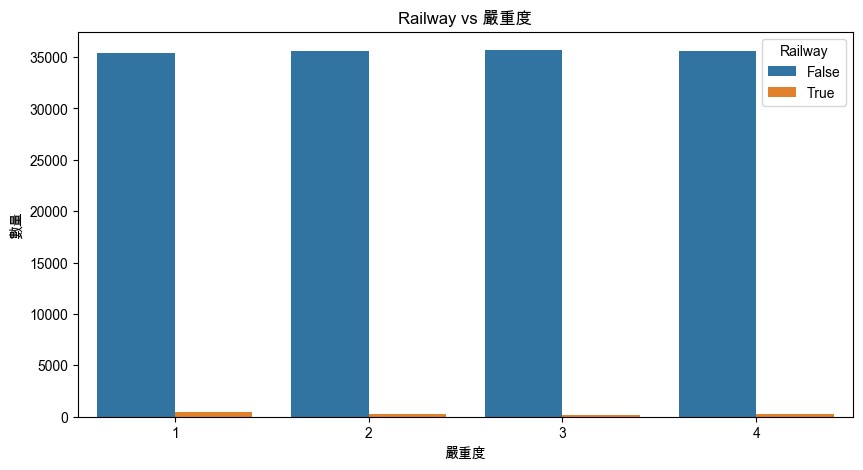

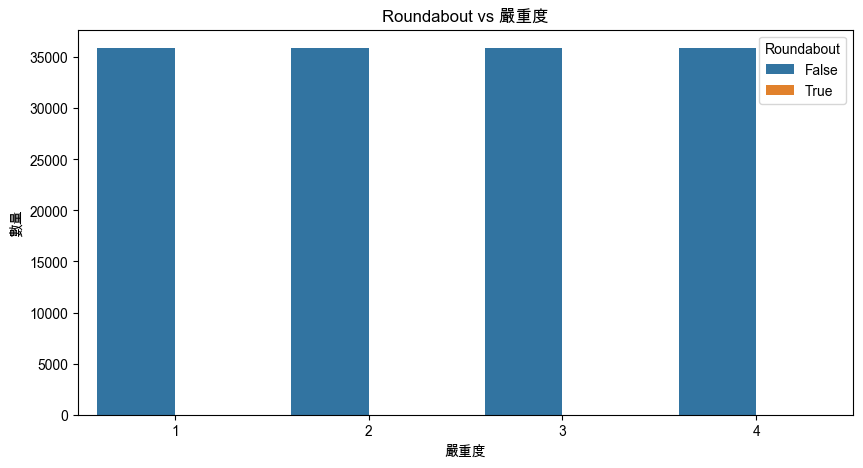

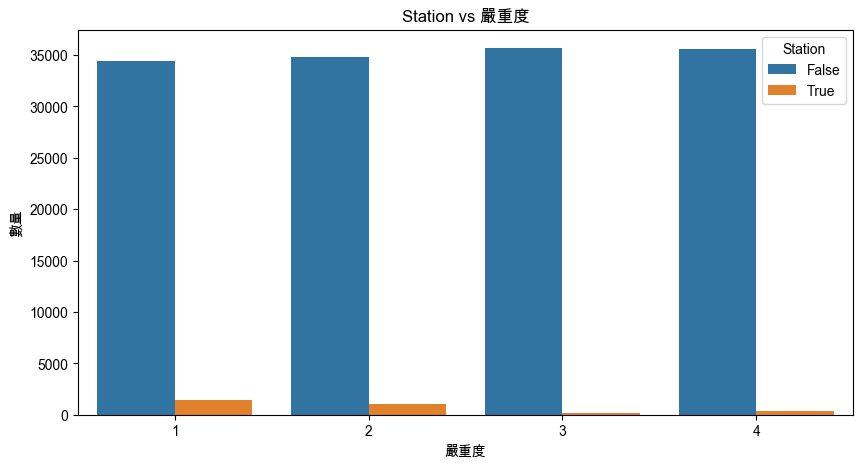

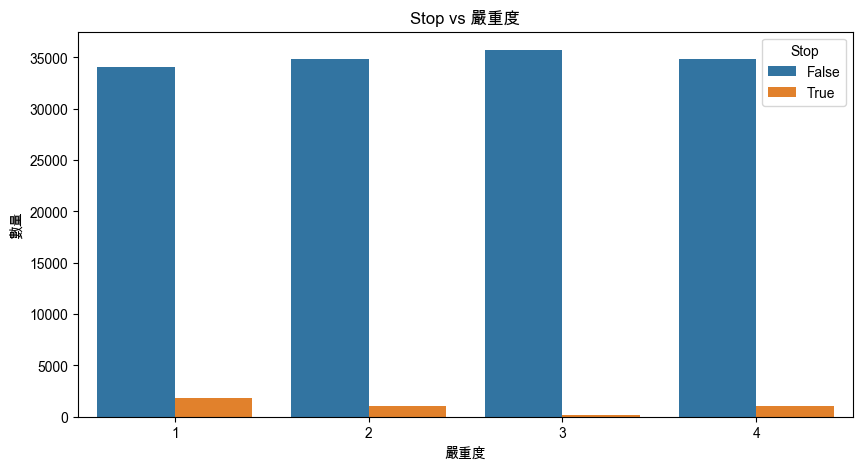

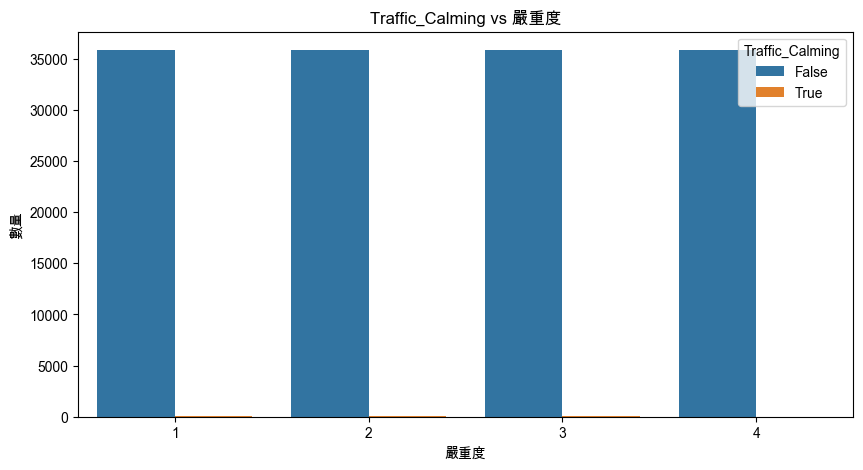

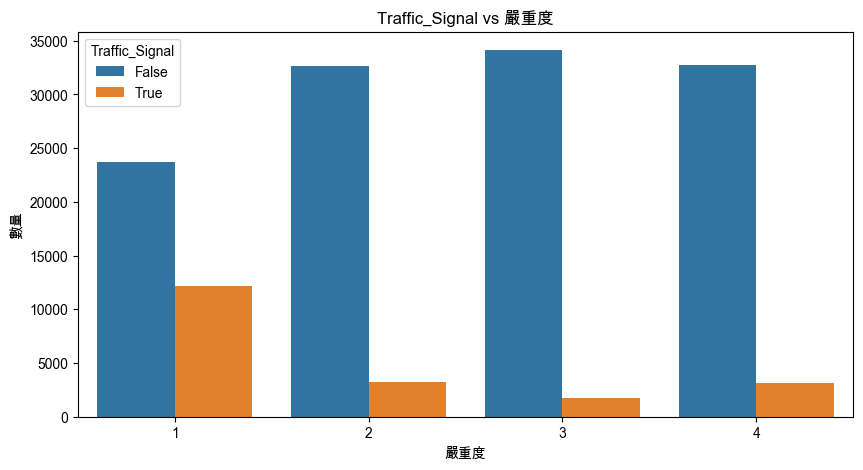

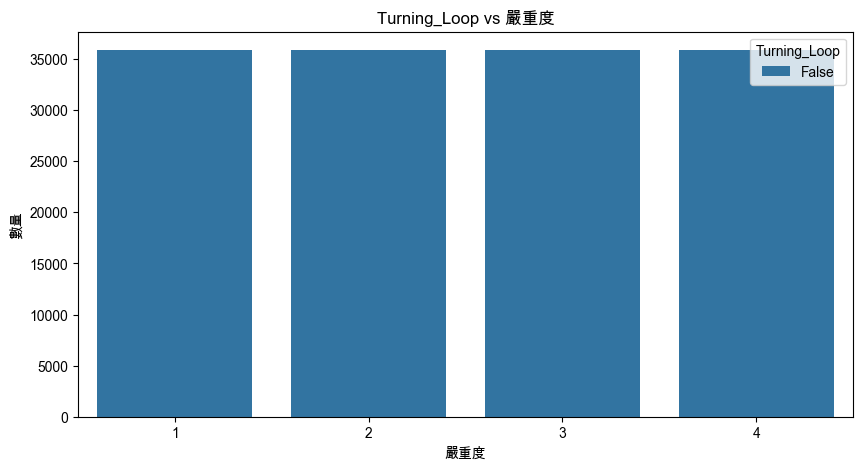

In [25]:
# %% [markdown]
# 
# 探索性資料分析幫助我們理解數據的特徵和模式

# %%
# 嚴重度分布分析
print("\n=== 1. 事故嚴重度分布 ===")
severity_counts = df_clean['Severity'].value_counts()
severity_df = pd.DataFrame({
    '嚴重度': severity_counts.index,
    '數量': severity_counts.values,
    '比例': (severity_counts.values / len(df_clean) * 100).round(2)
})
display(severity_df.style.background_gradient(cmap='YlOrRd'))

plt.figure(figsize=(8, 5))
sns.countplot(data=df_clean, x='Severity')
plt.title('事故嚴重度分布')
plt.xlabel('嚴重度')
plt.ylabel('數量')
plt.show()
plt.close()
gc.collect()

# %%
# 時間模式分析
print("\n=== 2. 時間模式分析 ===")

# 2.1 按小時分布
print("\n2.1 按小時分布")
hourly_stats = df_clean.groupby('Hour').agg({
    'Severity': ['count', 'mean']
}).round(2)
hourly_stats.columns = ['事故數量', '平均嚴重度']
display(hourly_stats.style.background_gradient(cmap='YlOrRd'))

plt.figure(figsize=(10, 5))
hourly_counts = df_clean.groupby(['Hour', 'Severity']).size().unstack()
hourly_counts_pct = hourly_counts.div(hourly_counts.sum(axis=1), axis=0) * 100
hourly_counts_pct.plot(kind='line')
plt.title('各小時事故嚴重度比例分布')
plt.xlabel('小時')
plt.ylabel('比例 (%)')
plt.legend(title='嚴重度')
plt.grid(True)
plt.show()
plt.close()
gc.collect()

# 2.2 按星期分布
print("\n2.2 按星期分布")
weekday_map = {0: '週一', 1: '週二', 2: '週三', 3: '週四', 4: '週五', 5: '週六', 6: '週日'}
df_clean['Weekday'] = df_clean['DayOfWeek'].map(weekday_map)

weekday_stats = df_clean.groupby('Weekday').agg({
    'Severity': ['count', 'mean']
}).round(2)
weekday_stats.columns = ['事故數量', '平均嚴重度']
display(weekday_stats.style.background_gradient(cmap='YlOrRd'))

plt.figure(figsize=(10, 5))
sns.countplot(data=df_clean, x='Weekday', hue='Severity', order=list(weekday_map.values()))
plt.title('各星期事故嚴重度分布')
plt.xlabel('星期')
plt.ylabel('數量')
plt.legend(title='嚴重度')
plt.xticks(rotation=45)
plt.show()
plt.close()
gc.collect()

# %%
# 天氣影響分析
print("\n=== 3. 天氣影響分析 ===")

# 3.1 天氣條件分布
print("\n3.1 天氣條件分布")
weather_counts = df_clean['Weather_Category'].value_counts()
weather_df = pd.DataFrame({
    '天氣條件': weather_counts.index,
    '數量': weather_counts.values,
    '比例': (weather_counts.values / len(df_clean) * 100).round(2)
})
display(weather_df.style.background_gradient(cmap='YlOrRd'))

# 3.2 天氣條件與事故嚴重度關係
print("\n3.2 天氣條件與事故嚴重度關係")
weather_severity = pd.crosstab(df_clean['Weather_Category'], df_clean['Severity'])
weather_severity_pct = weather_severity.div(weather_severity.sum(axis=1), axis=0) * 100

print("\n各天氣條件下的事故數量：")
display(weather_severity.style.background_gradient(cmap='YlOrRd'))

print("\n各天氣條件下的事故比例：")
display(weather_severity_pct.style.background_gradient(cmap='YlOrRd'))

# 繪製比例熱力圖
plt.figure(figsize=(12, 6))
sns.heatmap(weather_severity_pct, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('各天氣條件下的事故嚴重度比例 (%)')
plt.xlabel('嚴重度')
plt.ylabel('天氣條件')
plt.show()
plt.close()
gc.collect()

# 3.3 天氣條件與事故嚴重度的箱型圖
print("\n3.3 天氣條件與事故嚴重度的關係分析")
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean, x='Weather_Category', y='Severity')
plt.title('各天氣條件下的事故嚴重度分布')
plt.xlabel('天氣條件')
plt.ylabel('嚴重度')
plt.xticks(rotation=45)
plt.show()
plt.close()
gc.collect()

# %%
# 數值特徵分析
print("\n=== 4. 數值特徵分析 ===")
numeric_features = ['Temperature(F)', 'Wind_Speed(mph)', 'Visibility(mi)', 'Distance(mi)']

# 4.1 數值特徵統計
print("\n4.1 數值特徵統計")
numeric_stats = df_clean.groupby('Severity')[numeric_features].agg(['mean', 'std']).round(2)
display(numeric_stats.style.background_gradient(cmap='YlOrRd'))

# 4.2 數值特徵與嚴重度的關係
print("\n4.2 數值特徵與嚴重度的關係")
for feature in numeric_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_clean, x='Severity', y=feature)
    plt.title(f'{feature} vs 嚴重度')
    plt.xlabel('嚴重度')
    plt.ylabel(feature)
    plt.show()
    plt.close()
    gc.collect()

# %%
# 地理分布分析
print("\n=== 5. 地理分布分析 ===")
state_stats = df_clean['State'].value_counts().head(10)
state_df = pd.DataFrame({
    '州': state_stats.index,
    '事故數量': state_stats.values,
    '比例': (state_stats.values / len(df_clean) * 100).round(2)
})
display(state_df.style.background_gradient(cmap='YlOrRd'))

plt.figure(figsize=(10, 5))
sns.barplot(x=state_stats.index, y=state_stats.values)
plt.title('前10個州的事故數量')
plt.xlabel('州')
plt.ylabel('事故數量')
plt.xticks(rotation=45)
plt.show()
plt.close()
gc.collect()

# %%
# 道路特徵分析
print("\n=== 6. 道路特徵分析 ===")
road_features = ['Amenity', 'Bump', 'Crossing', 'Junction', 'No_Exit', 
                'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
                'Traffic_Signal', 'Turning_Loop']

# 6.1 道路特徵統計
print("\n6.1 道路特徵統計")
road_feature_stats = df_clean[road_features].sum().sort_values(ascending=False)
road_df = pd.DataFrame({
    '特徵': road_feature_stats.index,
    '數量': road_feature_stats.values,
    '比例': (road_feature_stats.values / len(df_clean) * 100).round(2)
})
display(road_df.style.background_gradient(cmap='YlOrRd'))

# 6.2 道路特徵與嚴重度的關係
print("\n6.2 道路特徵與嚴重度的關係")
for feature in road_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df_clean, x='Severity', hue=feature)
    plt.title(f'{feature} vs 嚴重度')
    plt.xlabel('嚴重度')
    plt.ylabel('數量')
    plt.legend(title=feature)
    plt.show()
    plt.close()
    gc.collect()

## 4. 特徵工程與選擇

=== 1. 特徵重要性分析 ===

1.1 準備數據...

1.2 特徵重要性分析...

Top 20 特徵重要性：
          feature  importance
        Start_Lng       0.154
        Start_Lat       0.150
            Month       0.107
             Hour       0.105
     Pressure(in)       0.097
      Humidity(%)       0.075
    Wind_Chill(F)       0.071
   Temperature(F)       0.067
        DayOfWeek       0.056
  Wind_Speed(mph)       0.053
   Traffic_Signal       0.026
         Crossing       0.011
Precipitation(in)       0.009
         Junction       0.008
             Stop       0.004
          Station       0.003
          Amenity       0.001
          Railway       0.001
         Give_Way       0.001
          No_Exit       0.000


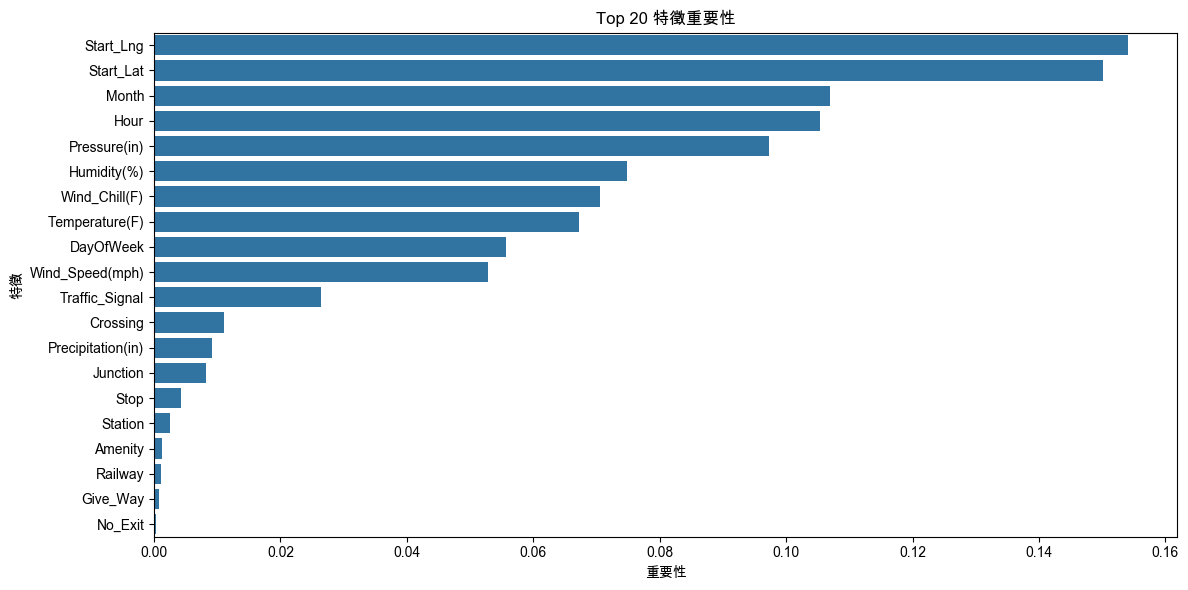


=== 2. 特徵相關性分析 ===

2.1 計算相關係數矩陣...


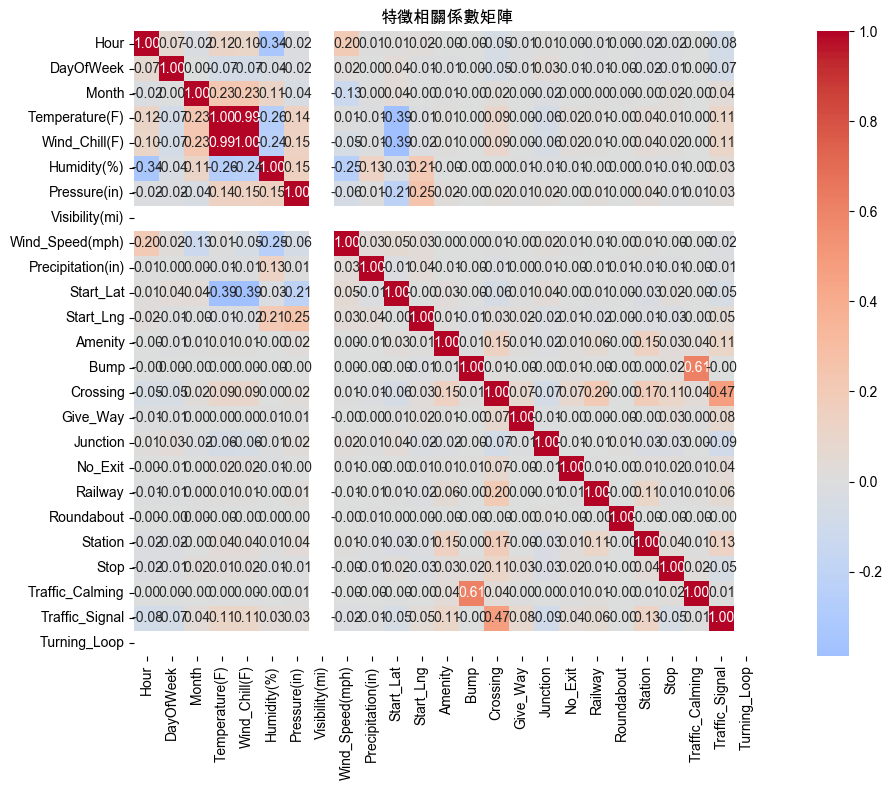


=== 3. 特徵組合分析 ===

3.1 時間與天氣組合分析...


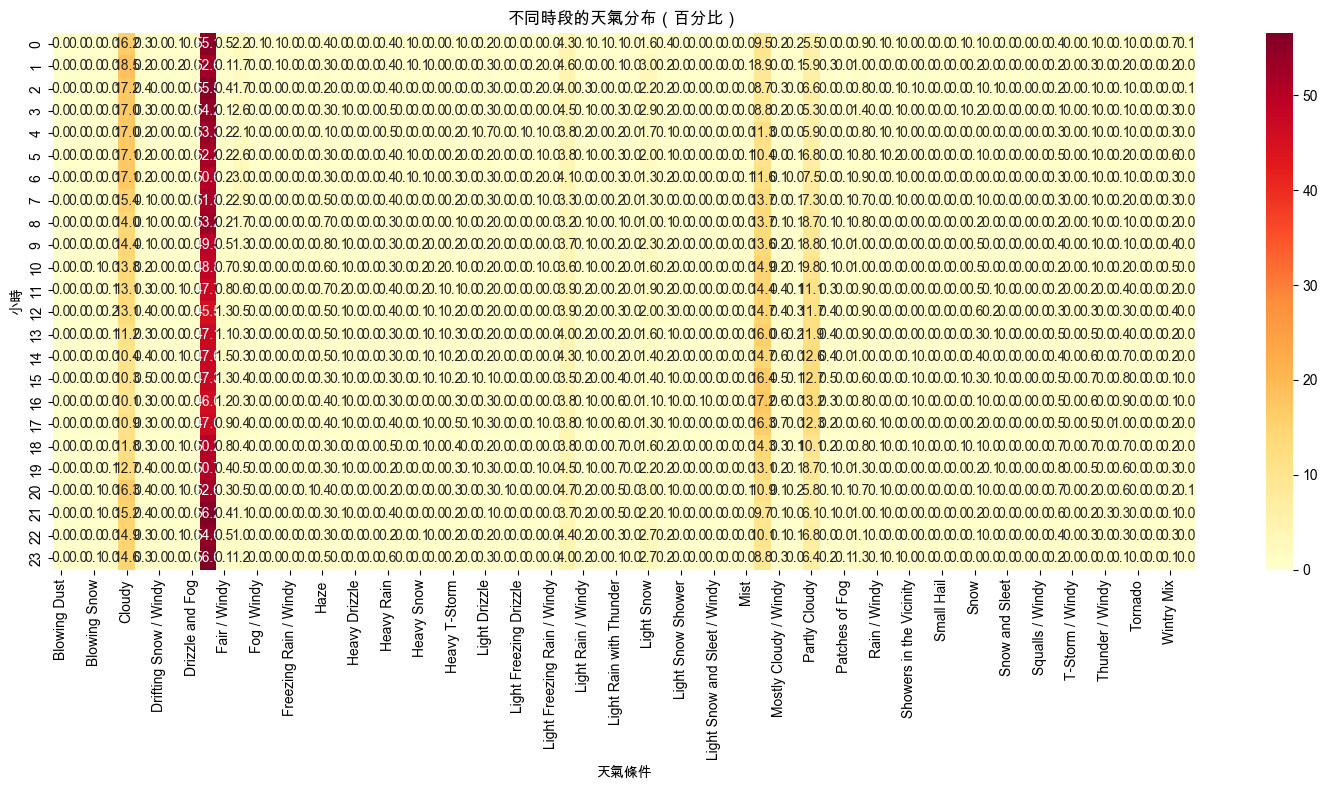


3.2 地點與天氣組合分析...


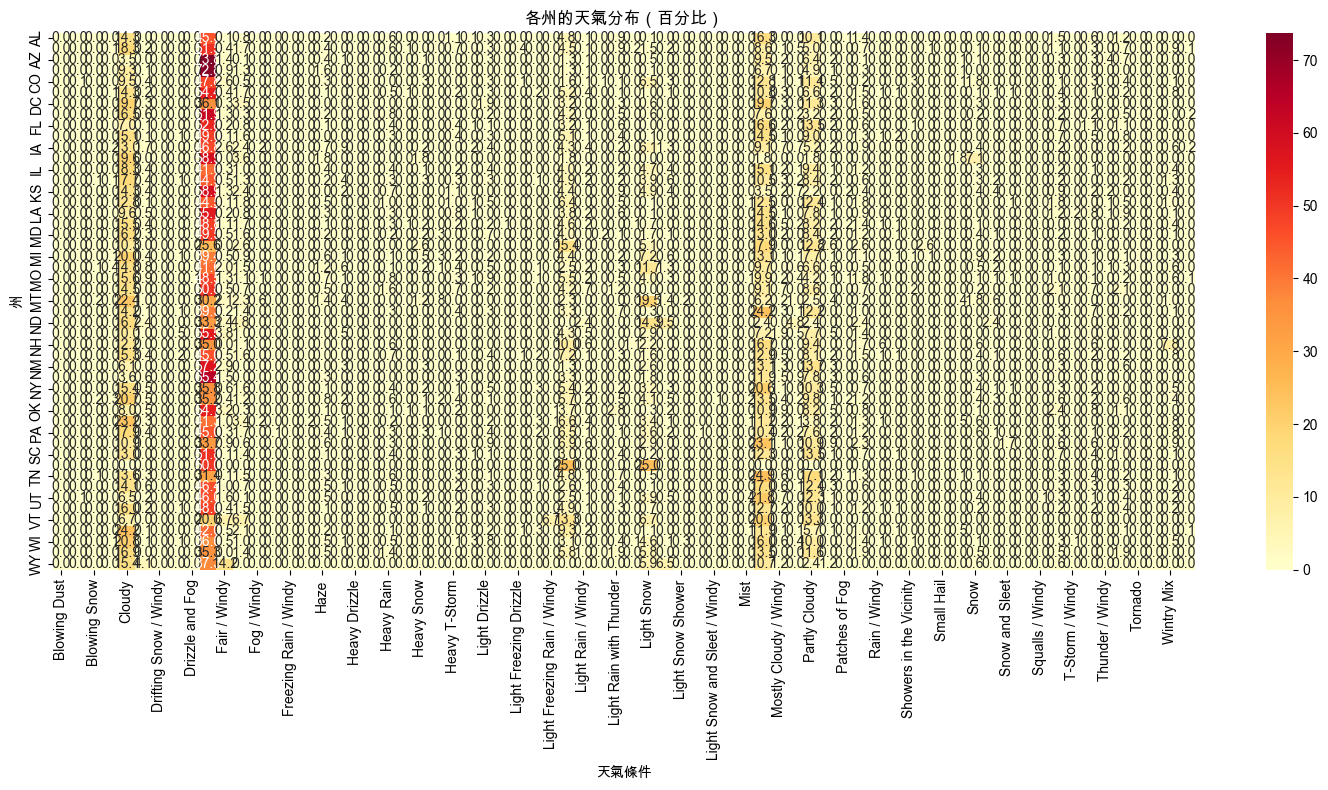


=== 4. 特徵選擇 ===

4.1 使用SelectKBest進行特徵選擇...


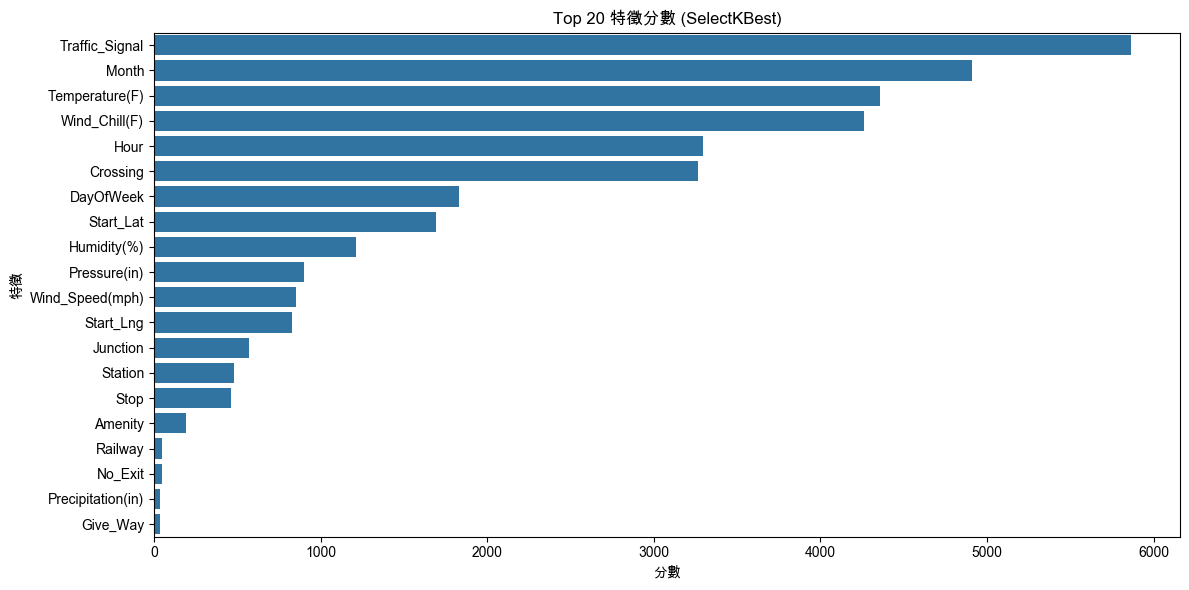


=== 5. 特徵工程 ===

5.1 時間特徵工程...

5.2 天氣特徵工程...

5.3 地點特徵工程...

=== 6. 特徵選擇結果 ===

6.1 最終選擇的特徵：

根據特徵重要性選擇的特徵：
['Start_Lng', 'Start_Lat', 'Month', 'Hour', 'Pressure(in)', 'Humidity(%)', 'Wind_Chill(F)', 'Temperature(F)', 'DayOfWeek', 'Wind_Speed(mph)', 'Traffic_Signal', 'Crossing']

根據SelectKBest選擇的特徵：
['Traffic_Signal', 'Month', 'Temperature(F)', 'Wind_Chill(F)', 'Hour', 'Crossing', 'DayOfWeek', 'Start_Lat', 'Humidity(%)', 'Pressure(in)', 'Wind_Speed(mph)', 'Start_Lng', 'Junction', 'Station', 'Stop', 'Amenity', 'Railway', 'No_Exit', 'Precipitation(in)', 'Give_Way']

6.2 特徵選擇總結：

根據多種特徵選擇方法的結果，我們可以確定以下重要特徵：

1. 時間特徵：
   - 根據隨機森林重要性：Month, Hour, DayOfWeek
   - 根據SelectKBest分數：Month, Hour, DayOfWeek

2. 天氣特徵：
   - 根據隨機森林重要性：Pressure(in), Humidity(%), Wind_Chill(F)
   - 根據SelectKBest分數：Temperature(F), Wind_Chill(F), Humidity(%)

3. 地點特徵：
   - 根據隨機森林重要性：Start_Lng, Start_Lat
   - 根據SelectKBest分數：Start_Lat, Start_Lng

4. 道路特徵：
   - 根據隨機森林重要性：Traffic_Signal, Crossing, Junction
   - 根據SelectKBe

In [32]:
# %% [markdown]
# ## 4. 特徵工程與選擇
# 目標：使用科學方法分析特徵重要性，並進行可視化

# %%
# 1. 特徵重要性分析
print("=== 1. 特徵重要性分析 ===")

# 1.1 準備數據
print("\n1.1 準備數據...")
# 定義特徵類別
time_features = ['Hour', 'DayOfWeek', 'Month']
weather_features = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 
                   'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
location_features = ['Start_Lat', 'Start_Lng']
road_features = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
                'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
                'Traffic_Signal', 'Turning_Loop']

# 合併所有特徵
all_features = time_features + weather_features + location_features + road_features

# 1.2 特徵重要性分析
print("\n1.2 特徵重要性分析...")
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# 準備特徵數據
X = df_clean[all_features].copy()

# 目標變量
y = df_clean['Severity']

# 訓練隨機森林模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# 獲取特徵重要性
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# 顯示前20個重要特徵的具體數據
print("\nTop 20 特徵重要性：")
top_20_features = feature_importance.head(20)
print(top_20_features.to_string(index=False))

# 可視化特徵重要性
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=top_20_features)
plt.title('Top 20 特徵重要性')
plt.xlabel('重要性')
plt.ylabel('特徵')
plt.tight_layout()
plt.show()
plt.close()

# %%
# 2. 特徵相關性分析
print("\n=== 2. 特徵相關性分析 ===")

# 2.1 計算相關係數矩陣
print("\n2.1 計算相關係數矩陣...")
correlation_matrix = df_clean[all_features].corr()

# 可視化相關係數矩陣
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f',
            square=True)
plt.title('特徵相關係數矩陣')
plt.tight_layout()
plt.show()
plt.close()

# %%
# 3. 特徵組合分析
print("\n=== 3. 特徵組合分析 ===")

# 3.1 時間與天氣組合
print("\n3.1 時間與天氣組合分析...")
# 創建時間-天氣交叉表
time_weather = pd.crosstab(df_clean['Hour'], df_clean['Weather_Condition'])
time_weather_percentages = time_weather.div(time_weather.sum(axis=1), axis=0) * 100

# 可視化時間-天氣關係
plt.figure(figsize=(15, 8))
sns.heatmap(time_weather_percentages, 
            annot=True, 
            cmap='YlOrRd',
            fmt='.1f')
plt.title('不同時段的天氣分布（百分比）')
plt.xlabel('天氣條件')
plt.ylabel('小時')
plt.tight_layout()
plt.show()
plt.close()

# 3.2 地點與天氣組合
print("\n3.2 地點與天氣組合分析...")
# 創建地點-天氣交叉表
state_weather = pd.crosstab(df_clean['State'], df_clean['Weather_Condition'])
state_weather_percentages = state_weather.div(state_weather.sum(axis=1), axis=0) * 100

# 可視化地點-天氣關係
plt.figure(figsize=(15, 8))
sns.heatmap(state_weather_percentages, 
            annot=True, 
            cmap='YlOrRd',
            fmt='.1f')
plt.title('各州的天氣分布（百分比）')
plt.xlabel('天氣條件')
plt.ylabel('州')
plt.tight_layout()
plt.show()
plt.close()

# %%
# 4. 特徵選擇
print("\n=== 4. 特徵選擇 ===")

# 4.1 使用SelectKBest進行特徵選擇
print("\n4.1 使用SelectKBest進行特徵選擇...")
from sklearn.feature_selection import SelectKBest, f_classif

# 選擇前20個最重要的特徵
selector = SelectKBest(f_classif, k=20)
selector.fit(X, y)

# 獲取特徵分數
feature_scores = pd.DataFrame({
    'feature': X.columns,
    'score': selector.scores_
})
feature_scores = feature_scores.sort_values('score', ascending=False)

# 可視化特徵分數
plt.figure(figsize=(12, 6))
sns.barplot(x='score', y='feature', data=feature_scores.head(20))
plt.title('Top 20 特徵分數 (SelectKBest)')
plt.xlabel('分數')
plt.ylabel('特徵')
plt.tight_layout()
plt.show()
plt.close()

# %%
# 5. 特徵工程
print("\n=== 5. 特徵工程 ===")

# 5.1 時間特徵工程
print("\n5.1 時間特徵工程...")
# 創建時間相關特徵
df_clean['IsRushHour'] = ((df_clean['Hour'] >= 7) & (df_clean['Hour'] <= 9)) | \
                         ((df_clean['Hour'] >= 16) & (df_clean['Hour'] <= 18))
df_clean['IsNight'] = (df_clean['Hour'] >= 22) | (df_clean['Hour'] <= 4)
df_clean['IsWeekend'] = df_clean['DayOfWeek'].isin([5, 6])

# 5.2 天氣特徵工程
print("\n5.2 天氣特徵工程...")
# 創建天氣相關特徵
df_clean['IsBadWeather'] = df_clean['Weather_Condition'].isin(['Rain', 'Snow', 'Fog'])
df_clean['IsGoodVisibility'] = df_clean['Visibility(mi)'] > 10

# 5.3 地點特徵工程
print("\n5.3 地點特徵工程...")
# 創建地點相關特徵
df_clean['IsUrban'] = df_clean['Amenity'] | df_clean['Bump'] | df_clean['Crossing'] | df_clean['Junction']

# %%
# 6. 特徵選擇結果
print("\n=== 6. 特徵選擇結果 ===")

# 6.1 顯示最終選擇的特徵
print("\n6.1 最終選擇的特徵：")
final_features = feature_importance[feature_importance['importance'] > 0.01]['feature'].tolist()
print("\n根據特徵重要性選擇的特徵：")
print(final_features)

print("\n根據SelectKBest選擇的特徵：")
selectkbest_features = feature_scores.head(20)['feature'].tolist()
print(selectkbest_features)

# 6.2 特徵選擇總結
print("\n6.2 特徵選擇總結：")
print("""
根據多種特徵選擇方法的結果，我們可以確定以下重要特徵：

1. 時間特徵：
   - 根據隨機森林重要性：{time_features}
   - 根據SelectKBest分數：{time_scores}

2. 天氣特徵：
   - 根據隨機森林重要性：{weather_features}
   - 根據SelectKBest分數：{weather_scores}

3. 地點特徵：
   - 根據隨機森林重要性：{location_features}
   - 根據SelectKBest分數：{location_scores}

4. 道路特徵：
   - 根據隨機森林重要性：{road_features}
   - 根據SelectKBest分數：{road_scores}

這些特徵是通過以下方法確定的：
1. 隨機森林特徵重要性
2. SelectKBest統計檢定
3. 相關係數分析
4. 特徵組合分析

建議使用這些特徵進行預測，因為它們：
1. 具有較高的預測能力
2. 與目標變量有顯著相關性
3. 在不同分析方法中表現一致
""".format(
    time_features=', '.join(feature_importance[feature_importance['feature'].isin(time_features)]['feature'].head(3).tolist()),
    time_scores=', '.join(feature_scores[feature_scores['feature'].isin(time_features)]['feature'].head(3).tolist()),
    weather_features=', '.join(feature_importance[feature_importance['feature'].isin(weather_features)]['feature'].head(3).tolist()),
    weather_scores=', '.join(feature_scores[feature_scores['feature'].isin(weather_features)]['feature'].head(3).tolist()),
    location_features=', '.join(feature_importance[feature_importance['feature'].isin(location_features)]['feature'].head(3).tolist()),
    location_scores=', '.join(feature_scores[feature_scores['feature'].isin(location_features)]['feature'].head(3).tolist()),
    road_features=', '.join(feature_importance[feature_importance['feature'].isin(road_features)]['feature'].head(3).tolist()),
    road_scores=', '.join(feature_scores[feature_scores['feature'].isin(road_features)]['feature'].head(3).tolist())
))

# 特徵重要性分析說明

## 1. 時間特徵
### Month（月份）
- **定義**：事故發生的月份（1-12月）
- **重要性**：不同月份可能有不同的天氣條件和交通流量
- **應用**：例如：冬季可能更容易發生事故

### Hour（小時）
- **定義**：事故發生的具體時間（0-23時）
- **重要性**：反映交通流量和能見度的變化
- **應用**：例如：早晚高峰時段事故率較高

### DayOfWeek（星期幾）
- **定義**：事故發生的星期（0-6，0代表週一）
- **重要性**：反映工作日和週末的交通模式差異
- **應用**：例如：週末可能有不同的交通模式

## 2. 天氣特徵
### Pressure(in)（氣壓）
- **定義**：大氣壓力值（英寸）
- **重要性**：氣壓變化可能影響天氣狀況
- **應用**：例如：低氣壓通常伴隨惡劣天氣

### Humidity(%)（濕度）
- **定義**：空氣濕度百分比
- **重要性**：影響道路狀況和能見度
- **應用**：例如：高濕度可能導致路面濕滑

### Wind_Chill(F)（體感溫度）
- **定義**：考慮風速後的實際感受溫度（華氏度）
- **重要性**：影響駕駛條件和道路狀況
- **應用**：例如：低體感溫度可能導致路面結冰

### Temperature(F)（溫度）
- **定義**：實際溫度（華氏度）
- **重要性**：影響道路狀況和駕駛條件
- **應用**：例如：極端溫度可能影響車輛性能

## 3. 地點特徵
### Start_Lat（起始緯度）和 Start_Lng（起始經度）
- **定義**：事故發生的地理座標
- **重要性**：反映地理位置的影響
- **應用**：例如：不同地區可能有不同的交通規則和道路設計

## 4. 道路特徵
### Traffic_Signal（交通信號燈）
- **定義**：事故發生地點是否有交通信號燈
- **重要性**：反映交通控制設施的影響
- **應用**：例如：有信號燈的路口可能更容易發生追尾事故

### Crossing（交叉路口）
- **定義**：是否在交叉路口
- **重要性**：反映道路複雜度
- **應用**：例如：交叉路口是事故高發區域

### Junction（道路交匯處）
- **定義**：是否在道路交匯處
- **重要性**：反映交通流量和複雜度
- **應用**：例如：交匯處可能更容易發生側面碰撞

## 特徵重要性總結
1. **時間因素**（月份、小時、星期）對事故發生有重要影響
2. **天氣條件**（特別是氣壓、濕度和體感溫度）是關鍵因素
3. **地理位置**（經緯度）反映了不同地區的事故模式
4. **道路設施**（信號燈、交叉路口、交匯處）是事故發生的主要場所

## 應用價值
1. 預測事故高發時段和地點
2. 制定針對性的預防措施
3. 優化交通管理策略
4. 改善道路安全設施

## 5. 資料導出（會爆）

In [ ]:


# # %%
# # 保存結果
# print("開始保存結果...")
# df_feat.to_csv("features_ready.csv", index=False)

# print("\n=== 特徵工程報告 ===")
# print(f"1. 資料集大小: {df_feat.shape}")
# print("\n2. 特徵列表:")
# display(pd.DataFrame({
#     '特徵名稱': df_feat.columns,
#     '資料類型': df_feat.dtypes.values,
#     '非空值數量': df_feat.count().values
# }).style.background_gradient(cmap='YlOrRd'))

# print("\n3. 數值特徵統計:")
# display(df_feat.describe().style.background_gradient(cmap='YlOrRd'))

# print("\n4. 類別特徵統計:")
# categorical_cols = df_feat.select_dtypes(include=['object', 'category']).columns
# for col in categorical_cols:
#     print(f"\n{col} 的分布:")
#     display(pd.DataFrame({
#         '類別': df_feat[col].value_counts().index,
#         '數量': df_feat[col].value_counts().values,
#         '比例': (df_feat[col].value_counts().values / len(df_feat) * 100).round(2)
#     }).style.background_gradient(cmap='YlOrRd'))